In [1]:
#!/usr/bin/python3

# Imports
import geopandas as gpd
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import pylab
from IPython.display import Image
import re
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import SGDClassifier
# from auto_ts import auto_timeseries

In [2]:
# Load Lawful Permanent Residents 2020 Data Tables
# Data from: https://www.dhs.gov/immigration-statistics/yearbook/2020
directory = "./data/lawful2020/"

# Title: PERSONS OBTAINING LAWFUL PERMANENT RESIDENT STATUS: FISCAL YEARS 1820 TO 2020
lawful2020_table1_in = pd.read_excel(directory + "fy2020_table1.xlsx", skiprows=3, nrows=60)

# Reformat into 2 columns: Year and Number
lawful2020_table1 = pd.DataFrame(columns=['Year', 'Number'])
lawful2020_table1['Year'] = lawful2020_table1_in['Year']
lawful2020_table1['Number'] = lawful2020_table1_in['Number']
for i in range(3):
    temp = pd.DataFrame(columns=['Year','Number'])
    current_col_year = 'Year.' + str(i + 1)
    current_col_number = 'Number.' + str(i + 1)
    temp['Year'] = lawful2020_table1_in[current_col_year]
    temp['Number'] = lawful2020_table1_in[current_col_number]
    lawful2020_table1 = pd.concat([lawful2020_table1, temp])
    
# Remove rows with NaN
lawful2020_table1 = lawful2020_table1.dropna()

# Modify one instance of a string
lawful2020_table1.loc[lawful2020_table1['Year'] == "1976¹"] = 1976

print(lawful2020_table1.describe())

             Number
count  2.010000e+02
mean   4.288578e+05
std    3.651173e+05
min    1.976000e+03
25%    1.411320e+05
50%    3.216250e+05
75%    6.033220e+05
max    1.826595e+06


In [3]:
# Load Lawful Permanent Residents 2020 Supplementary Data Tables

# Title: PERSONS OBTAINING LAWFUL PERMANENT RESIDENT STATUS: FISCAL YEARS 1820 TO 2020
lawful2020_table2_in = pd.read_excel(directory + "fy2020_table2.xlsx", skiprows=3, nrows=88)
df = lawful2020_table2_in

# Make sure all column names are strings (2020 label saved as int)
df = df.rename(columns={2020:'2020'})

# Rename a column
df = df.rename(columns={"Region and country of last residence1": "Region"})

# Rename a row element
df.iloc[87]['Region'] = 'Not Specified'

# Replace NaN with 0, replace dashes with 0
df = df.fillna(0)
df.loc[:, df.columns != 'Region'] = df.loc[:, df.columns != 'Region'].replace('-',0, regex=True)

# Combine 2010-2019 and 2020 columns
df['2010 to 2020'] = df['2010 to 2019'] + df['2020']

# Remove a column
df = df.drop('2010 to 2019', axis=1)
df = df.drop('2020', axis=1)

print(df.head())

               Region 1820 to 1829 1830 to 1839 1840 to 1849 1850 to 1859  \
0               Total       128502       538381      1427337      2814554   
1              Europe        99618       422853      1369423      2622617   
2  Austria-Hungary2,3            0            0            0            0   
3          Austria2,3            0            0            0            0   
4          Hungary2,3            0            0            0            0   

  1860 to 1869 1870 to 1879 1880 to 1889 1890 to 1899 1900 to 1909  ...  \
0      2081261      2742137      5248568      3694294      8202388  ...   
1      1880389      2252050      4638684      3576411      7572569  ...   
2         3375        60127       314787       534059      2001376  ...   
3         2700        54529       204805       268218       532416  ...   
4          483         5598       109982       203350       685567  ...   

  1920 to 1929 1930 to 1939 1940 to 1949 1950 to 1959 1960 to 1969  \
0      4295510  

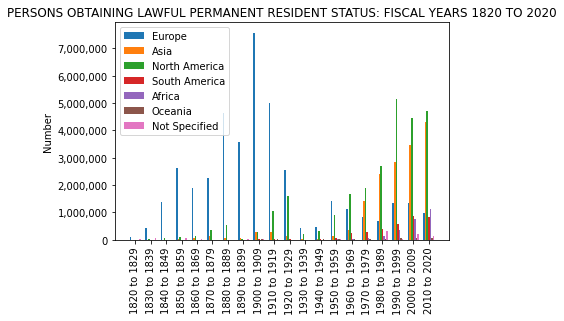

In [4]:
# Create plot of persons by continent

continent_data = df[(df['Region'] == 'Europe') | (df['Region'] == 'Asia') | (df['Region'] == 'America') | (df['Region'] == 'South America') | (df['Region'] == 'Africa') | (df['Region'] == 'Oceania') | (df['Region'] == 'Not Specified')]

labels = continent_data.iloc[:, 0].tolist()
europe_data = continent_data.iloc[0,1:].tolist()
asia_data = continent_data.iloc[1,1:].tolist()
america_data = continent_data.iloc[2,1:].tolist()
sa_data = continent_data.iloc[3,1:].tolist()
africa_data = continent_data.iloc[4,1:].tolist()
oceania_data = continent_data.iloc[5,1:].tolist()
other_data = continent_data.iloc[6,1:].tolist()

bar_labels = continent_data.columns.tolist()
bar_labels = bar_labels[1:]

x = np.arange(len(europe_data))
width = 0.1
fig, ax = plt.subplots()

europe_bars = ax.bar((x - (3 * width)), europe_data, width, label='Europe')
asia_bars = ax.bar((x - (2 * width)), asia_data, width, label='Asia')
america_bars = ax.bar((x - (1 * width)), america_data, width, label='North America')
sa_bars = ax.bar(x, sa_data, width, label='South America')
africa_bars = ax.bar((x + (1 * width)), africa_data, width, label='Africa')
oceania_bars = ax.bar((x + (2 * width)), oceania_data, width, label='Oceania')
other_bars = ax.bar((x + (3 * width)), other_data, width, label='Not Specified')

ax.set_xticks(x, bar_labels, rotation='vertical')
ax.set_ylabel('Number')
ax.set_title('PERSONS OBTAINING LAWFUL PERMANENT RESIDENT STATUS: FISCAL YEARS 1820 TO 2020')
ax.legend()

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, a: format(int(x), ',')))

plt.show()

## Ancestry Data 2010-2020 5 year

In [5]:
# Load ancestry census data from 2020
# Import correct sheet in file
df_2020_5 = pd.read_csv('./data/5yr/2020_5yr.csv', skiprows=141, nrows = 25)
df_2020_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2020 = df_2020_5['Ancestry'][1:]
population_data_2020_5 = df_2020_5['Number'][1:]
df_2020_5.replace(',','', regex=True, inplace=True)
df_2020_5['Number'] = df_2020_5['Number'].astype(int)


# Load ancestry census data from 2019
# Import correct sheet in file
df_2019_5 = pd.read_csv('./data/5yr/2019_5yr.csv', skiprows=140, nrows = 25)
df_2019_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2019_5 = df_2019_5['Ancestry'][1:]
population_data_2019_5 = df_2019_5['Number'][1:]
df_2019_5.replace(',','', regex=True, inplace=True)
df_2019_5['Number'] = df_2019_5['Number'].astype(int)


# Load ancestry census data from 2018
# Import correct sheet in file
df_2018_5 = pd.read_csv('./data/5yr/2018_5yr.csv', skiprows=139, nrows = 25)
df_2018_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2018 = df_2018_5['Ancestry'][1:]
population_data_2018_5 = df_2018_5['Number'][1:]
df_2018_5.replace(',','', regex=True, inplace=True)
df_2018_5['Number'] = df_2018_5['Number'].astype(int)


# Load ancestry census data from 2017
# Import correct sheet in file
df_2017_5 = pd.read_csv('./data/5yr/2017_5yr.csv', skiprows=139, nrows = 25)
df_2017_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2017 = df_2017_5['Ancestry'][1:]
population_data_2017_5 = df_2017_5['Number'][1:]
df_2017_5.replace(',','', regex=True, inplace=True)
df_2017_5['Number'] = df_2017_5['Number'].astype(int)


# Load ancestry census data from 2016
# Import correct sheet in file
df_2016_5 = pd.read_csv('./data/5yr/2016_5yr.csv', skiprows=139, nrows = 25)
df_2016_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2016_5 = df_2016_5['Ancestry'][1:]
population_data_2016_5 = df_2016_5['Number'][1:]
df_2016_5.replace(',','', regex=True, inplace=True)
df_2016_5['Number'] = df_2016_5['Number'].astype(int)


# Load ancestry census data from 2015
# Import correct sheet in file
df_2015_5 = pd.read_csv('./data/5yr/2015_5yr.csv', skiprows=139, nrows = 25)
df_2015_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2015_5 = df_2015_5['Ancestry'][1:]
population_data_2015_5 = df_2015_5['Number'][1:]
df_2015_5.replace(',','', regex=True, inplace=True)
df_2015_5['Number'] = df_2015_5['Number'].astype(int)


# Load ancestry census data from 2014
# Import correct sheet in file
df_2014_5 = pd.read_csv('./data/5yr/2014_5yr.csv', skiprows=139, nrows = 25)
df_2014_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2014_5 = df_2014_5['Ancestry'][1:]
population_data_2014_5 = df_2014_5['Number'][1:]
df_2014_5.replace(',','', regex=True, inplace=True)
df_2014_5['Number'] = df_2014_5['Number'].astype(int)


# Load ancestry census data from 2013
# Import correct sheet in file
df_2013_5 = pd.read_csv('./data/5yr/2013_5yr.csv', skiprows=139, nrows = 25)
df_2013_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2013 = df_2013_5['Ancestry'][1:]
population_data_2013_5 = df_2013_5['Number'][1:]
df_2013_5.replace(',','', regex=True, inplace=True)
df_2013_5['Number'] = df_2013_5['Number'].astype(int)

# Load ancestry census data from 2012
# Import correct sheet in file
df_2012_5 = pd.read_csv('./data/5yr/2012_5yr.csv', skiprows=139, nrows = 25)
df_2012_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2012_5 = df_2012_5['Ancestry'][1:]
population_data_2012_5 = df_2012_5['Number'][1:]
df_2012_5.replace(',','', regex=True, inplace=True)
df_2012_5['Number'] = df_2012_5['Number'].astype(int)


# Load ancestry census data from 2011
# Import correct sheet in file
df_2011_5 = pd.read_csv('./data/5yr/2011_5yr.csv', skiprows=139, nrows = 25)
df_2011_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2011_5 = df_2011_5['Ancestry'][1:]
population_data_2011_5 = df_2011_5['Number'][1:]
df_2011_5.replace(',','', regex=True, inplace=True)
df_2011_5['Number'] = df_2011_5['Number'].astype(int)


# Load ancestry census data from 2010
# Import correct sheet in file
df_2010_5 = pd.read_csv('./data/5yr/2010_5yr.csv', skiprows=139, nrows = 25)
df_2010_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2010_5 = df_2010_5['Ancestry'][1:]
population_data_2010_5 = df_2010_5['Number'][1:]
df_2010_5.replace(',','', regex=True, inplace=True)
df_2010_5['Number'] = df_2010_5['Number'].astype(int)


## Ancestry Data 2010-2019 1 year 

In [6]:
# Load ancestry census data from 2010 1yr
# Import correct sheet in file
df_2010_1 = pd.read_csv('./data/1yr/2010_1yr.csv', skiprows=139, nrows = 25)
df_2010_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2010_1 = df_2010_1['Ancestry'][1:]
population_data_2010_1 = df_2010_1['Number'][1:]
df_2010_1.replace(',','', regex=True, inplace=True)
df_2010_1['Number'] = df_2010_1['Number'].astype(int)


# Load ancestry census data from 2011 1yr
# Import correct sheet in file
df_2011_1 = pd.read_csv('./data/1yr/2011_1yr.csv', skiprows=139, nrows = 25)
df_2011_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2011 = df_2011_1['Ancestry'][1:]
population_data_2011_1 = df_2011_1['Number'][1:]
df_2011_1.replace(',','', regex=True, inplace=True)
df_2011_1['Number'] = df_2011_1['Number'].astype(int)


# Load ancestry census data from 2012 1yr
# Import correct sheet in file
df_2012_1 = pd.read_csv('./data/1yr/2012_1yr.csv', skiprows=139, nrows = 25)
df_2012_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2012 = df_2012_1['Ancestry'][1:]
population_data_2012_1 = df_2012_1['Number'][1:]
df_2012_1.replace(',','', regex=True, inplace=True)
df_2012_1['Number'] = df_2012_1['Number'].astype(int)


# Load ancestry census data from 2013 1yr
# Import correct sheet in file
df_2013_1 = pd.read_csv('./data/1yr/2013_1yr.csv', skiprows=139, nrows = 25)
df_2013_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2013_1 = df_2013_1['Ancestry'][1:]
population_data_2013_1 = df_2013_1['Number'][1:]
df_2013_1.replace(',','', regex=True, inplace=True)
df_2013_1['Number'] = df_2013_1['Number'].astype(int)


# Load ancestry census data from 2014 1yr
# Import correct sheet in file
df_2014_1 = pd.read_csv('./data/1yr/2014_1yr.csv', skiprows=139, nrows = 25)
df_2014_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2014_1 = df_2014_1['Ancestry'][1:]
population_data_2014_1 = df_2014_1['Number'][1:]
df_2014_1.replace(',','', regex=True, inplace=True)
df_2014_1['Number'] = df_2014_1['Number'].astype(int)


# Load ancestry census data from 2015 1yr
# Import correct sheet in file
df_2015_1 = pd.read_csv('./data/1yr/2015_1yr.csv', skiprows=139, nrows = 25)
df_2015_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2015_1 = df_2015_1['Ancestry'][1:]
population_data_2015_1 = df_2015_1['Number'][1:]
df_2015_1.replace(',','', regex=True, inplace=True)
df_2015_1['Number'] = df_2015_1['Number'].astype(int)


# Load ancestry census data from 2016 1yr
# Import correct sheet in file
df_2016_1 = pd.read_csv('./data/1yr/2016_1yr.csv', skiprows=139, nrows = 25)
df_2016_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2016_1 = df_2016_1['Ancestry'][1:]
population_data_2016_1 = df_2016_1['Number'][1:]
df_2016_1.replace(',','', regex=True, inplace=True)
df_2016_1['Number'] = df_2016_1['Number'].astype(int)


# Load ancestry census data from 2017 1yr
# Import correct sheet in file
df_2017_1 = pd.read_csv('./data/1yr/2017_1yr.csv', skiprows=139, nrows = 25)
df_2017_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2017_1 = df_2017_1['Ancestry'][1:]
population_data_2017_1 = df_2017_1['Number'][1:]
df_2017_1.replace(',','', regex=True, inplace=True)
df_2017_1['Number'] = df_2017_1['Number'].astype(int)


# Load ancestry census data from 2018 1yr
# Import correct sheet in file
df_2018_1 = pd.read_csv('./data/1yr/2018_1yr.csv', skiprows=139, nrows = 25)
df_2018_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2018_1 = df_2018_1['Ancestry'][1:]
population_data_2018_1 = df_2018_1['Number'][1:]
df_2018_1.replace(',','', regex=True, inplace=True)
df_2018_1['Number'] = df_2018_1['Number'].astype(int)


# Load ancestry census data from 2019 1yr
# Import correct sheet in file
df_2019_1 = pd.read_csv('./data/1yr/2019_1yr.csv', skiprows=140, nrows = 25)
df_2019_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2019_1 = df_2019_1['Ancestry'][1:]
population_data_2019_1 = df_2019_1['Number'][1:]
df_2019_1.replace(',','', regex=True, inplace=True)
df_2019_1['Number'] = df_2019_1['Number'].astype(int)


## Aggregate 5 yr Dataframe and Graph

In [7]:
df_joined_5 = pd.DataFrame()
df_joined_5['Ancestry'] = df_2020_5['Ancestry']
df_joined_5['N_2010'] = df_2010_5['Number']
df_joined_5['N_2011'] = df_2011_5['Number']
df_joined_5['N_2012'] = df_2012_5['Number']
df_joined_5['N_2013'] = df_2013_5['Number']
df_joined_5['N_2014'] = df_2014_5['Number']
df_joined_5['N_2015'] = df_2015_5['Number']
df_joined_5['N_2016'] = df_2016_5['Number']
df_joined_5['N_2017'] = df_2017_5['Number']
df_joined_5['N_2018'] = df_2018_5['Number']
df_joined_5['N_2019'] = df_2019_5['Number']
df_joined_5['N_2020'] = df_2020_5['Number']
df_joined_5['Ancestry'] = df_joined_5['Ancestry'].str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_5_T = df_joined_5.transpose()
df_joined_5_T = df_joined_5_T.rename(columns=df_joined_5_T.iloc[0])
df_joined_5_T.drop(index=df_joined_5_T.index[0], axis=0, inplace=True)
df_joined_5_T.columns = df_joined_5_T.columns.str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_5_T

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Polish,Portuguese,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian
N_2010,19094109,1517664,1595844,1453897,4950041,27403063,9326180,2138601,49836146,1337511,...,9835459,1426121,3072756,5227821,5821321,805282,2763624,4293208,1003505,956896
N_2011,19911467,1584874,1569839,1420962,4809836,26922124,9135933,2087970,49202203,1319128,...,9739640,1422191,3060143,5102732,5706263,786108,2828270,4211644,982909,958294
N_2012,20775461,1646808,1543224,1392161,4665736,26360639,8902996,2052405,48478298,1308335,...,9670197,1409262,3013959,3317115,5580121,769697,2886972,4155453,967123,960902
N_2013,21659006,1710927,1514919,1360858,4533617,25809471,8678917,2061608,47715461,1300818,...,9596630,1404692,2964169,3212402,5485459,754862,2931557,4067207,951617,958662
N_2014,22365250,1769645,1479588,1323182,4387814,25181294,8431568,2052979,46874293,1285866,...,9452375,1380904,2895600,3102082,5401397,735757,2987143,3984136,936806,963549
N_2015,22746991,1832106,1452344,1307381,4289116,24787018,8272538,2059482,46403053,1284473,...,9385766,1372141,2843400,3046005,5409343,725457,3119177,3933024,929291,973257
N_2016,21961129,1883456,1435359,1297738,4210787,24426623,8151499,2084903,45879360,1282655,...,9344126,1367476,2795443,3056848,5457798,714557,3232142,3908762,937376,986597
N_2017,21227906,1920562,1410576,1294689,4121110,23977180,7997196,2109242,45153215,1272806,...,9265548,1363703,2741864,3032134,5460745,700474,3402702,3847046,933084,995653
N_2018,20678613,1979363,1382835,1278457,4009279,23638645,7815721,2095503,44164758,1273100,...,9152819,1358190,2671995,3021077,5440934,688103,3589855,3788741,927539,1002367
N_2019,20266321,2009626,1358610,1265727,3872651,23493906,7606589,2074567,43038145,1265177,...,9095241,1368091,2608040,3011165,5398961,675728,3748931,3718915,921436,1009119


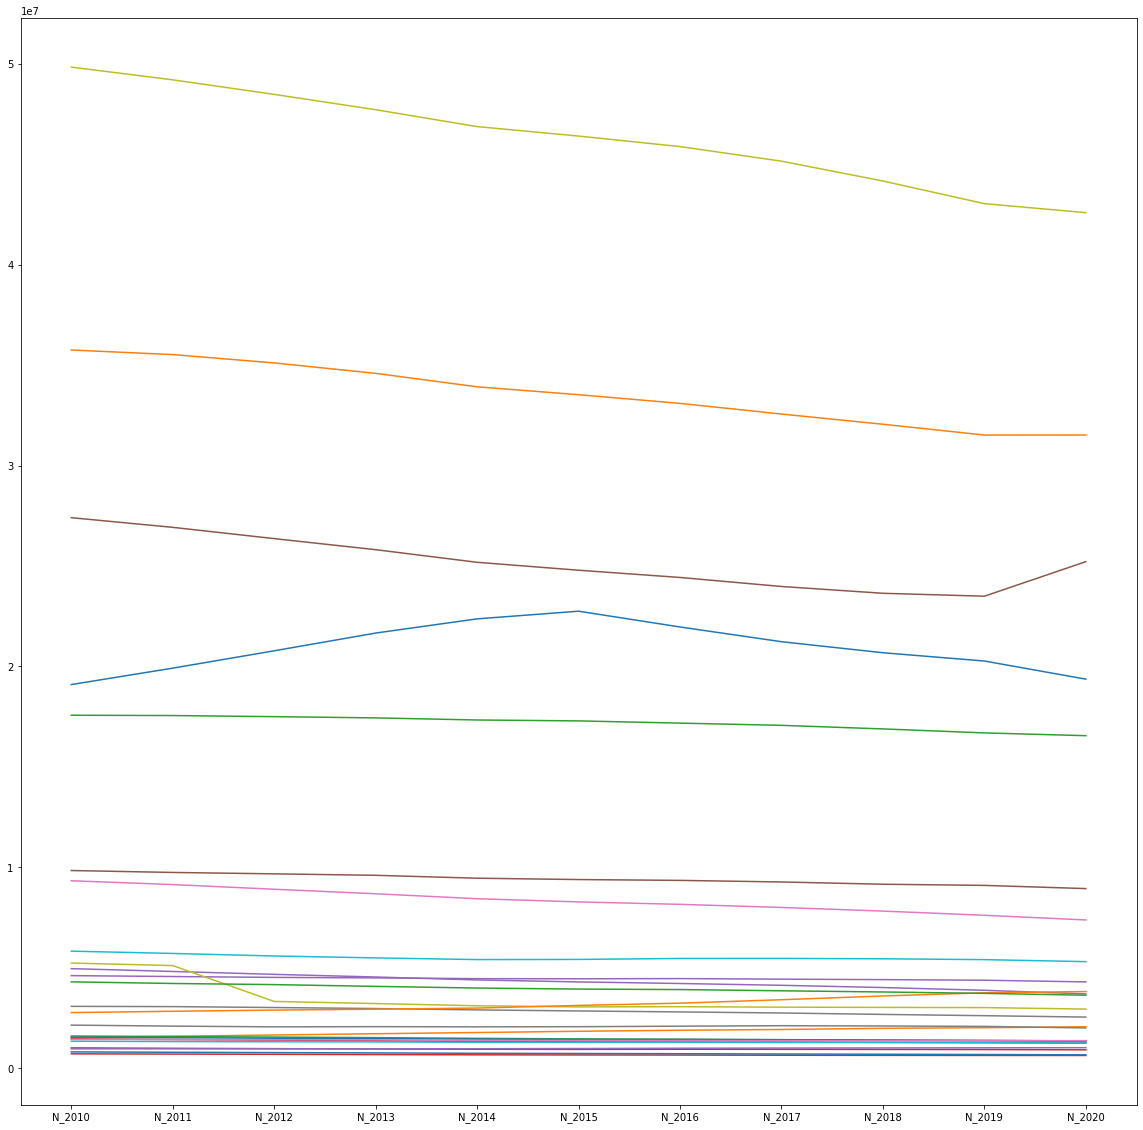

<Figure size 360x720 with 0 Axes>

In [8]:
fig = pylab.figure(figsize = (20,20))
figlegend = pylab.figure(figsize=(5,10))
ax = fig.add_subplot(111)
lines = ax.plot(df_joined_5_T)
figlegend.legend(lines, ('American', 'Arab','Czech','Danish','Dutch','English','French (except Basque)',
                         'French Canadian','German','Greek','Hungarian', 'Irish', 'Italian','Lithuanian',
                         'Norwegian','Polish','Portuguese','Russian','Scotch-Irish','Scottish','Slovak',
                         'Subsaharan African','Swedish','Swiss','Ukrainian'), 'center')

figlegend.savefig('./data/ancestry_line_graph/legend.png')
fig.savefig('./data/ancestry_line_graph/graph.png')

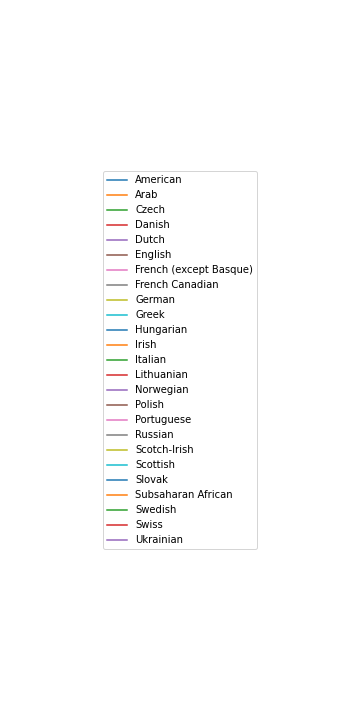

In [9]:
Image(filename = "./data/ancestry_line_graph/legend.png", width=500, height=500)

## Aggregate 1 yr Dataframe and Graph

In [10]:
df_joined_1 = pd.DataFrame()
df_joined_1['Ancestry'] = df_2010_1['Ancestry']
df_joined_1['N_2010'] = df_2010_1['Number']
df_joined_1['N_2011'] = df_2011_1['Number']
df_joined_1['N_2012'] = df_2012_1['Number']
df_joined_1['N_2013'] = df_2013_1['Number']
df_joined_1['N_2014'] = df_2014_1['Number']
df_joined_1['N_2015'] = df_2015_1['Number']
df_joined_1['N_2016'] = df_2016_1['Number']
df_joined_1['N_2017'] = df_2017_1['Number']
df_joined_1['N_2018'] = df_2018_1['Number']
df_joined_1['N_2019'] = df_2019_1['Number']
df_joined_1['Ancestry'] = df_joined_1['Ancestry'].str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_1_T = df_joined_1.transpose()
df_joined_1_T = df_joined_1_T.rename(columns=df_joined_1_T.iloc[0])
df_joined_1_T.drop(index=df_joined_1_T.index[0], axis=0, inplace=True)
df_joined_1_T.columns = df_joined_1_T.columns.str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_1_T

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Polish,Portuguese,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian
N_2010,19975875,1646371,1525187,1375506,4645131,25926451,8761496,2042808,47901779,1315775,...,9569207,1405909,2971599,3257161,5460679,762030,2789129,4088555,961380,939746
N_2011,24144605,1769251,1508360,1335678,4440324,25695922,8595793,1971979,47383539,1280777,...,9447905,1379381,2994598,3143906,5412820,730373,2928281,4001651,916314,958470
N_2012,23567147,1798991,1507815,1296751,4350633,25261814,8475331,1992174,46875013,1296119,...,9500696,1380877,2895912,3117627,5379735,742738,3008961,3980614,941692,968769
N_2013,22217931,1822511,1441072,1311484,4271869,24483225,8227938,2100842,46162557,1265072,...,9383332,1373756,2844709,2976878,5310285,720203,3076544,3912522,917071,968754
N_2014,22097012,1927432,1419630,1275222,4243067,24382182,8153515,2099430,46047113,1295703,...,9249392,1340026,2762830,2978827,5365154,706662,3223885,3887273,939268,984157
N_2015,21844951,1963478,1391020,1315302,4141375,23959441,7969633,2072053,45526331,1280897,...,9231299,1373147,2723176,2981519,5510902,704601,3482384,3829029,915091,986698
N_2016,20151829,2032892,1412051,1295169,4044507,23835787,7962052,2120016,44754050,1278174,...,9258128,1375288,2754205,3212692,5658914,687243,3557902,3867110,957460,1028492
N_2017,20024830,2005223,1379037,1284171,3906193,23074947,7673619,2110014,43093766,1246095,...,9012085,1371701,2608412,3007722,5399371,670681,3893865,3683020,916404,1006636
N_2018,19613477,2110727,1298652,1220506,3688602,22807283,7275203,2032630,41222462,1284153,...,8887304,1334145,2502911,2933199,5212119,654642,4015406,3614939,900022,996884
N_2019,20071406,2097642,1294789,1215809,3577936,23593434,7116099,1994739,40363511,1247142,...,8969530,1371153,2432733,2924654,5131171,654150,4018144,3536320,905079,1009874


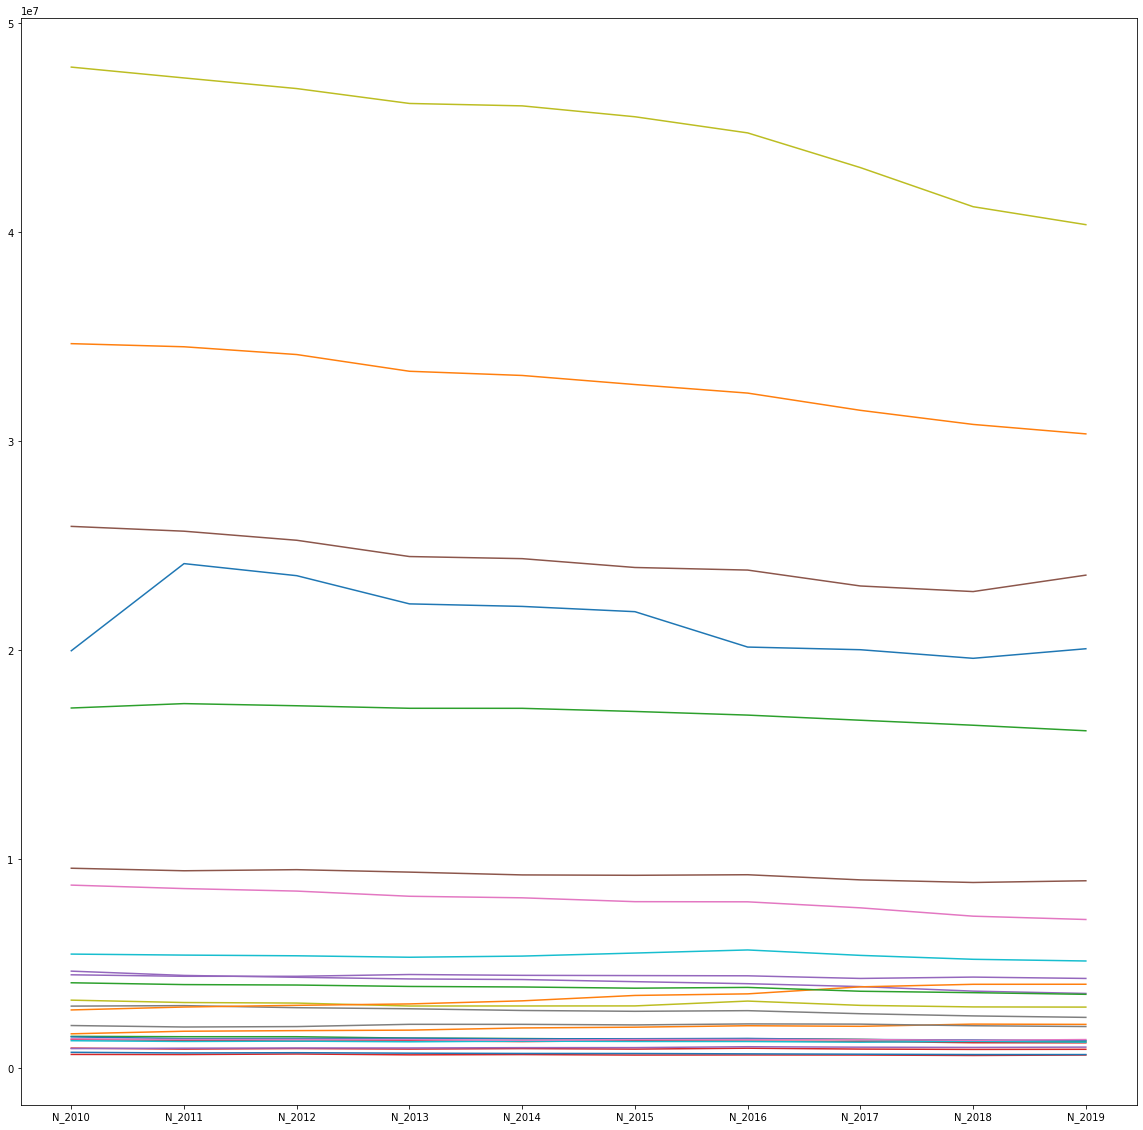

<Figure size 360x720 with 0 Axes>

In [11]:
fig = pylab.figure(figsize = (20,20))
figlegend = pylab.figure(figsize=(5,10))
ax = fig.add_subplot(111)
lines = ax.plot(df_joined_1_T)
figlegend.legend(lines, ('American', 'Arab','Czech','Danish','Dutch','English','French (except Basque)',
                         'French Canadian','German','Greek','Hungarian', 'Irish', 'Italian','Lithuanian',
                         'Norwegian','Polish','Portuguese','Russian','Scotch-Irish','Scottish','Slovak',
                         'Subsaharan African','Swedish','Swiss','Ukrainian'), 'center')

figlegend.savefig('./data/ancestry_line_graph/legend_1.png')
fig.savefig('./data/ancestry_line_graph/graph_1.png')

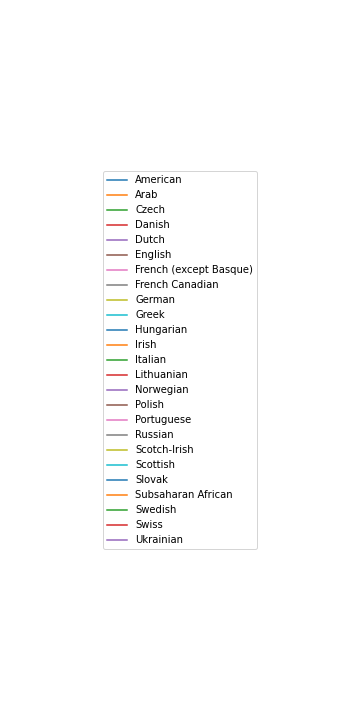

In [12]:
Image(filename = "./data/ancestry_line_graph/legend_1.png", width=500, height=500)

## Prediction Model Testing (1 year)

In [13]:
#train = pd.DataFrame(df_joined_1_T[df_joined_1_T.index < "N_2017"])
#test = pd.DataFrame(df_joined_1_T[df_joined_1_T.index >= "N_2017"])

# https://builtin.com/data-science/time-series-forecasting-python
# https://towardsdatascience.com/train-multiple-time-series-forecasting-models-in-one-line-of-python-code-615f2253b67a

train = df_joined_1_T[df_joined_1_T.index < "N_2017"]
test = df_joined_1_T[df_joined_1_T.index >= "N_2017"]

In [14]:
train

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Polish,Portuguese,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian
N_2010,19975875,1646371,1525187,1375506,4645131,25926451,8761496,2042808,47901779,1315775,...,9569207,1405909,2971599,3257161,5460679,762030,2789129,4088555,961380,939746
N_2011,24144605,1769251,1508360,1335678,4440324,25695922,8595793,1971979,47383539,1280777,...,9447905,1379381,2994598,3143906,5412820,730373,2928281,4001651,916314,958470
N_2012,23567147,1798991,1507815,1296751,4350633,25261814,8475331,1992174,46875013,1296119,...,9500696,1380877,2895912,3117627,5379735,742738,3008961,3980614,941692,968769
N_2013,22217931,1822511,1441072,1311484,4271869,24483225,8227938,2100842,46162557,1265072,...,9383332,1373756,2844709,2976878,5310285,720203,3076544,3912522,917071,968754
N_2014,22097012,1927432,1419630,1275222,4243067,24382182,8153515,2099430,46047113,1295703,...,9249392,1340026,2762830,2978827,5365154,706662,3223885,3887273,939268,984157
N_2015,21844951,1963478,1391020,1315302,4141375,23959441,7969633,2072053,45526331,1280897,...,9231299,1373147,2723176,2981519,5510902,704601,3482384,3829029,915091,986698
N_2016,20151829,2032892,1412051,1295169,4044507,23835787,7962052,2120016,44754050,1278174,...,9258128,1375288,2754205,3212692,5658914,687243,3557902,3867110,957460,1028492


In [15]:
test

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Polish,Portuguese,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian
N_2017,20024830,2005223,1379037,1284171,3906193,23074947,7673619,2110014,43093766,1246095,...,9012085,1371701,2608412,3007722,5399371,670681,3893865,3683020,916404,1006636
N_2018,19613477,2110727,1298652,1220506,3688602,22807283,7275203,2032630,41222462,1284153,...,8887304,1334145,2502911,2933199,5212119,654642,4015406,3614939,900022,996884
N_2019,20071406,2097642,1294789,1215809,3577936,23593434,7116099,1994739,40363511,1247142,...,8969530,1371153,2432733,2924654,5131171,654150,4018144,3536320,905079,1009874


In [16]:
# df_train = df_joined_1[['Ancestry','N_2010', 'N_2011', 'N_2012', 'N_2013', 'N_2014', 'N_2015', 'N_2016']]
# df_test = df_joined_1[['Ancestry','N_2017', 'N_2018', 'N_2019']]


In [17]:
#model = auto_timeseries(forecast_period=219, score_type='rmse',
#                        time_interval='D', model_type = 'best')
#model.fit(traindata = df_train, ts_column="Date", target="Close")


In [18]:
AR_model = SARIMAX(train['American'].astype(float), order = (1, 0, 1))

/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [19]:
AR_model = AR_model.fit()

In [20]:
y_pred = AR_model.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = AR_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [21]:
y_pred_df

,lower American,upper American,Predictions
N_2017,1.720152e+07,1.999862e+07,1.860007e+07
N_2018,1.557931e+07,2.150524e+07,1.854228e+07
N_2019,1.454004e+07,2.242928e+07,1.848466e+07


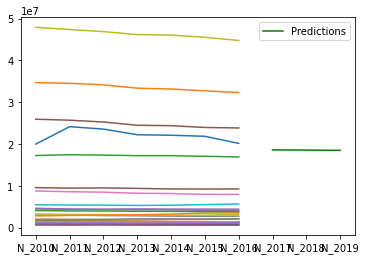

In [22]:
plt.plot(train)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [23]:
arma_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  1377820.7848749626


/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few

RMSE:  288886.8631828366


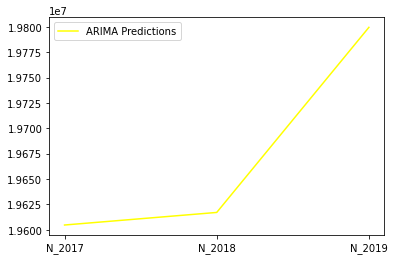

In [24]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['American'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [25]:
y_pred_df

,lower American,upper American,Predictions
N_2017,1.650773e+07,2.270186e+07,1.960479e+07
N_2018,1.472943e+07,2.450492e+07,1.961717e+07
N_2019,1.364734e+07,2.595170e+07,1.979952e+07


In [26]:
america_df = test['American']
america_df

N_2017    20024830
N_2018    19613477
N_2019    20071406
Name: American, dtype: object

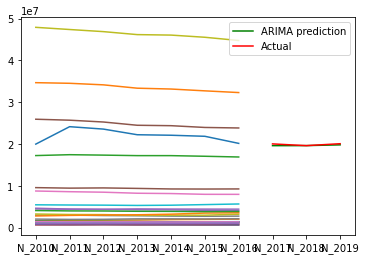

In [27]:
# See how ARIMA matches up with American ancestry data 2017-2019
plt.plot(train)
plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

plt.plot(america_df, color='red', label = 'Actual')
plt.legend()

In [28]:
sarimax_m = SARIMAX(train['American'].astype(float), order = (6, 1, 3), seasonal_order=(2,2,2,12))
sarimax_m = sarimax_m.fit()

y_pred = sarimax_m.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = sarimax_m.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index

sarimax_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df["Predictions"]))
print("RMSE: ", sarimax_rmse)

/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters e

RMSE:  322707.0295866958


/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


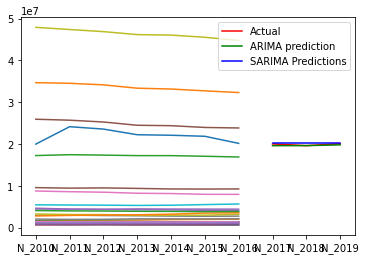

In [29]:
# See how SARIMA matches up with American ancestry data 2017-2019
plt.plot(train)

plt.plot(america_df, color='red', label = 'Actual')
plt.legend()

plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

y_pred_out_sarima = y_pred_df["Predictions"] 
plt.plot(y_pred_out_sarima, color='Blue', label = 'SARIMA Predictions')
plt.legend()

Here, we can see that a model using ARIMA is better than a model using SARIMA for this specific problem. This makes sense, since this dataset contains values over entire years instead of smaller seasonal subsets of data.

In [30]:
### Experimentation with other models ###

# Imports, make classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
clf = KNeighborsClassifier(7)

# Create x
nationalities = len(train.iloc[0])
N_train = len(train.iloc[:,0])
N_test = len(test.iloc[:,0])

train_x = np.zeros((2, nationalities*N_train))
test_x = np.zeros((2, nationalities*N_test))
train_x = train.to_numpy().flatten()
test_x = test.to_numpy().flatten()

# Create y
train_y = []
test_y = []
for x in range(nationalities):
    for i in range(N_train):
        train_y.append(float(x))
    for i in range(N_test):
        test_y.append(float(x))

train_y = np.asarray(train_y)
test_y = np.asarray(test_y)

# Normalize x 
# train_x_normalized = np.zeros((2, nationalities*N_train))
# test_x_normalized = np.zeros((2, nationalities*N_test))

# train_x_normalized /= np.mean(train_x[0])
# test_x_normalized /= np.mean(test_x[0])

# train_x_normalized = np.matrix(train_x_normalized).T
# test_x_normalized = np.matrix(test_x_normalized).T

train_x = np.matrix(train_x).T
test_x = np.matrix(test_x).T

# Fit model
clf.fit(train_x, train_y)

# Predict model
train_pred = clf.predict(train_x)
test_pred = clf.predict(test_x)

# Check accuracy
accuracy_train = accuracy_score(train_y, train_pred)
accuracy_test = accuracy_score(test_y, test_pred)

print("Training accuracy: ", accuracy_train)
print("Testing accuracy: ", accuracy_test)

Training accuracy:  0.15428571428571428
Testing accuracy:  0.04


Creating a model like this does not make sense conceptually. Given our dataset and the problem that we are trying to solve, a method such as time series forecasting (see above) is more appropriate.

## Prediction Model Testing (5 year)

In [31]:
train = df_joined_5_T[df_joined_5_T.index < "N_2017"]
test = df_joined_5_T[df_joined_5_T.index >= "N_2017"]

In [32]:
print(test.columns)

Index(['American', 'Arab', 'Czech', 'Danish', 'Dutch', 'English',
       'French (except Basque)', 'French Canadian', 'German', 'Greek',
       'Hungarian', 'Irish', 'Italian', 'Lithuanian', 'Norwegian', 'Polish',
       'Portuguese', 'Russian', 'Scotch-Irish', 'Scottish', 'Slovak',
       'Subsaharan African', 'Swedish', 'Swiss', 'Ukrainian'],
      dtype='object')


/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few

RMSE:  868808.4236607179


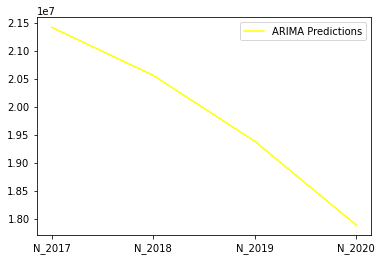

In [33]:
# Use ARIMA again
ARIMAmodel = ARIMA(train['American'].astype(float), order = (6, 3, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [34]:
america_df = test['American']
america_df

N_2017    21227906
N_2018    20678613
N_2019    20266321
N_2020    19364103
Name: American, dtype: object

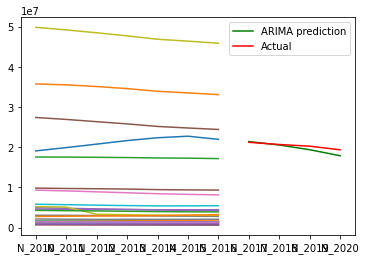

In [35]:
# See how ARIMA model predicts
plt.plot(train)
plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

plt.plot(america_df, color='red', label = 'Actual')
plt.legend()

# Prediction Model Testing (Immigration Data 1820-2020)

In [36]:
# Preprocessing

# Load Lawful Permanent Residents 2020 Supplementary Data Tables

# Title: PERSONS OBTAINING LAWFUL PERMANENT RESIDENT STATUS: FISCAL YEARS 1820 TO 2020
lawful2020_table2_in = pd.read_excel(directory + "fy2020_table2.xlsx", skiprows=3, nrows=88)
df = lawful2020_table2_in

# Make sure all column names are strings (2020 label saved as int)
df = df.rename(columns={2020:'2020'})

# Rename a column
df = df.rename(columns={"Region and country of last residence1": "Region"})

# Rename a row element
df.iloc[87]['Region'] = 'Not Specified'

# Replace NaN with 0, replace dashes with 0
df = df.fillna(0)
df.loc[:, df.columns != 'Region'] = df.loc[:, df.columns != 'Region'].replace('-',0, regex=True)

# Combine 2010-2019 and 2020 columns
df['2010 to 2020'] = df['2010 to 2019'] + df['2020']

# Remove a column
df = df.drop('2010 to 2019', axis=1)
df = df.drop('2020', axis=1)

In [40]:
# Check the columns (for train/test split)
df.columns

Index(['Region', '1820 to 1829', '1830 to 1839', '1840 to 1849',
       '1850 to 1859', '1860 to 1869', '1870 to 1879', '1880 to 1889',
       '1890 to 1899', '1900 to 1909', '1910 to 1919', '1920 to 1929',
       '1930 to 1939', '1940 to 1949', '1950 to 1959', '1960 to 1969',
       '1970 to 1979', '1980 to 1989', '1990 to 1999', '2000 to 2009',
       '2010 to 2020'],
      dtype='object')

In [45]:
train = df[df.columns[1:18]] # 1820-1829 to 1980-1989
test = df[df.columns[18:20]] # 1990-1999 to 2010-2020

In [61]:
df_1990 = test['1990 to 1999']

RMSE:  1264654.6436438153


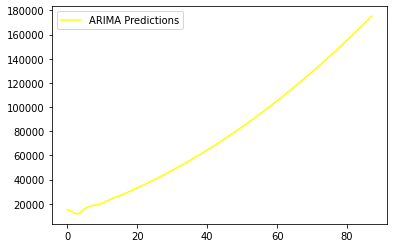

In [54]:
# Use ARIMA again
ARIMAmodel = ARIMA(train['1820 to 1829'].astype(float), order = (6, 3, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test['1990 to 1999'].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

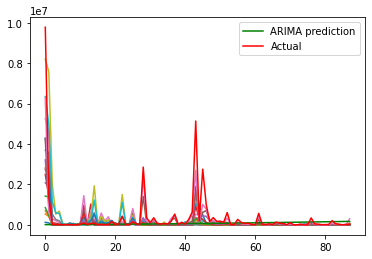

In [62]:
# See how ARIMA model predicts
plt.plot(train)
plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

plt.plot(df_1990, color='red', label = 'Actual')
plt.legend()